# Continuous-time stochastic model: SIR model

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# import numba
import scipy.stats
from scipy.integrate import solve_ivp
from functools import partial
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

# SIR model

A very common model in epidemiology is the compartmental model, which stands for _Susceptible_, _Infectious_, and _Recovered_.
\begin{align}
\text{Susceptible} \rightarrow \text{Infectious} \rightarrow \text{Recovered}
\end{align}

A more quantitative description is:

- Susceptible individuals contact other individuals with rate $\beta$, and with probability $\frac{I}{N}$ it is an Infectious individual.
- Infectious individuals recover with rate $\gamma$ 

where $N=S+I+R$ is the total population size.

![diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/SIR_model_cartoon.png/320px-SIR_model_cartoon.png)

The model was first introduced as a discrete-time deterministic model in
> Kermack, W.O., and A.G. McKendrick. 1927. “A Contribution to the Mathematical Theory of Epidemics.” Proceedings of the Royal Society of London, Series A.

# Continuous-time deterministic model
The _deterministic_ equations, which describe the dynamics over a very large number of individuals, are

$$
\frac{dS}{dt} = -\beta I S , \\
\frac{dI}{dt} = \beta I S - \gamma I, \\
\frac{dR}{dt} = \gamma I
$$

Importantly, we assume new $S$ individuals are not produced, that is, the population size $N=S+I+R$ is constant throughout the epidemic. This means there is an implicit assumption that the pandemic is "faster" than the population growth rate. 
So we will just assume $S$, $I$, and $R$ are frequencies and $S+I+R=1$.

This gives the constraint
$$
\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0 ,
$$
which reduces the degrees of freedom in the system, just like in the logistic growth model. This is different from the predator-prey model, in which new prey constantly entered the system.

## Analytic solution

We use the [separation of variables method](https://upload.wikimedia.org/wikipedia/commons/2/21/Sept_proportional_differential_equation.png): 

$$
\frac{dS}{dR} = -\frac{\beta I S}{\gamma I} = -\frac{\beta}{\gamma} S \Rightarrow \\
\frac{1}{S} dS = -\frac{\beta}{\gamma} dR \Rightarrow \\
\int \frac{1}{S} dS = - \int \frac{\beta}{\gamma} dR \Rightarrow \\
\log{S} + C_1 = - \frac{\beta}{\gamma} R + C_2 \Rightarrow \\
S(t) = e^{- \frac{\beta}{\gamma} R(t)} \tilde C
$$
We can add the boundary conditions now, $S(0)=S_0$, $R(0)=0$,
$$
S(0) = e^{- \frac{\beta}{\gamma} R(0)} \tilde C \Rightarrow \\
S_0 = \tilde C
$$

So we have
$$
S(t) = S_0 e^{- \frac{\beta}{\gamma} R(t)} 
$$

Of course, $R(t)$ is also a variable, so this is not a solution.

One trivial solution occurs if $R(t)==0$ always, such that $S(t)==S_0$ always--but this can only occur if $I(0)==0$ because otherwise an infected individual will recover and so $R(t)>0$ for some $t$.

At the limit $t \to \infty$, we get $S^*=S(\infty) = 1-R(\infty)$, and 
$$
S^* = S_0 e^{-\frac{\beta}{\gamma}(1-S^*)} = S_0 e^{-\frac{\beta}{\gamma}}e^{\frac{\beta}{\gamma}S^*} \Rightarrow \\
S^* e^{-\frac{\beta}{\gamma}S^*} = S_0 e^{-\frac{\beta}{\gamma}} \Rightarrow \\
-\frac{\beta}{\gamma} S^* e^{-\frac{\beta}{\gamma}S^*} = -S_0\frac{\beta}{\gamma} e^{-\frac{\beta}{\gamma}}
$$

This can be solved in terms of a [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function) (we saw this function in the population genetics session, but also see see [Lehtonen 2016](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/2041-210X.12568)):
$$
S^* = -\frac{\gamma}{\beta} W\left(-S_0 \frac{\beta}{\gamma} e^{-\beta/\gamma}\right), R^* = 1-S^*
$$


**See Wong 2010 to finish this.**

In [25]:
from scipy.special import lambertw as W

def analytic_solution(S0, β, γ):
    R0 = β/γ # reproductive number
    Sstar = -1/R0 * W(-S0 * R0 * np.exp(-R0))
    assert Sstar.imag == 0
    return Sstar.real

## Numerical solution

We will solve the ODE numerically just as we did in previous classes.

In [28]:
def gradient(t, SI, β, γ):
    S, I = SI
    dSdt = -β * S * I 
    dIdt = β * S * I - γ * I
    return (dSdt, dIdt)

def numerical_solution(β, γ, I0, tmax=250, tsteps=1000):
    gradient_ = partial(gradient, β=β, γ=γ)
    t = np.linspace(0, tmax, tsteps)
    sol = solve_ivp(gradient_, t_span=(0, t.max()), y0=(1-I0, I0), t_eval=t)
    S, I = sol.y
    return t, S, I, 1-S-I

def plot_SIR(t, S, I, R, label='', ls='-', ax=None):
    ax.plot(t, S, lw=3, ls=ls, color=green, label='S ' + label)
    ax.plot(t, I, lw=3, ls=ls, color=red, label='I ' + label)
    ax.plot(t, R, lw=3, ls=ls, color=blue, label='R ' + label)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Frequency')
    return ax

Now can plot the numerical solution for specific parameters and compare to the analytic solution.

Note that the rates are given units of events per day.

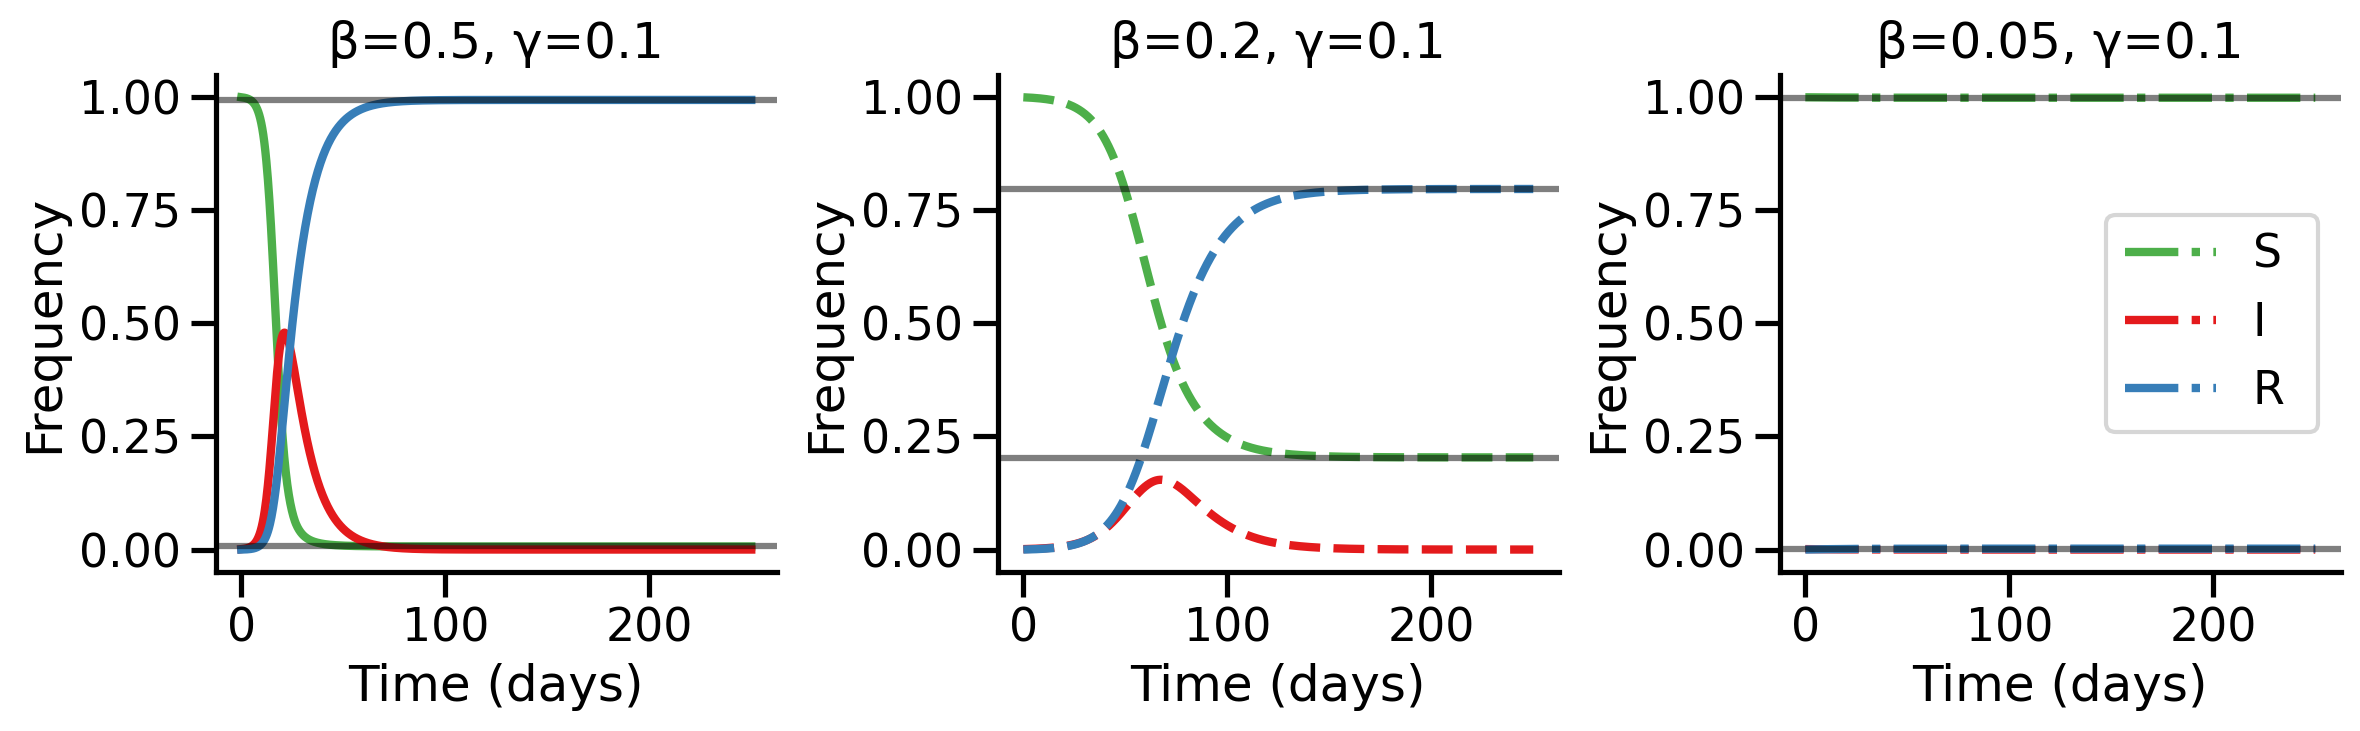

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
hline_kws = dict(ls='-', alpha=0.5, color='k')
I0 = 0.001
S0 = 1 - I0

ax = axes[0]
β, γ = 0.5, 0.1
t, S, I, R = numerical_solution(β, γ, I0)
plot_SIR(t, S, I, R, ax=ax)
ax.axhline(analytic_solution(S0, β, γ), **hline_kws)
ax.axhline(1-analytic_solution(S0, β, γ), **hline_kws)
ax.set_title('β={}, γ={}'.format(β, γ))

ax = axes[1]
β, γ = 0.2, 0.1
t, S, I, R = numerical_solution(β, γ, I0)
plot_SIR(t, S, I, R, ls='--', ax=ax)
ax.axhline(analytic_solution(S0, β, γ), **hline_kws)
ax.axhline(1-analytic_solution(S0, β, γ), **hline_kws)
ax.set_title('β={}, γ={}'.format(β, γ))

ax = axes[2]
β, γ = 0.05, 0.1
t, S, I, R = numerical_solution(β, γ, I0)
plot_SIR(t, S, I, R, ls='-.', ax=ax)
ax.axhline(analytic_solution(S0, β, γ), **hline_kws)
ax.axhline(1-analytic_solution(S0, β, γ), **hline_kws)
ax.set_title('β={}, γ={}'.format(β, γ))
ax.legend()

fig.tight_layout()
sns.despine()

# Stochastic model

To deal with stochasticity of the system, we need to describe it using a stochastic model -- using a distribution, rather than just the mean value. That's the difference between a deterministic and a stochastic model.

Let $f_t(S, I, R)$ be the probability of $S$ susceptibles, $I$ infectious, and $R$ recovered at time $t$.
It represents a distribution on the number of individuals in each compartment at each time point.

How does this distribution $f_t(S, I, R)$ change over time? Individuals become infected and then recover. How does it affect the distribution?

At time $t$, there is probability $f_t(S,I,R)$ that the state is $(S, I, R)$.
The rates $\beta$ and $\gamma$ are all in 1/days.
Now, we choose a time interval $dt$ that is so small that the probability that more then one event (one infection, one recovery) is negligible.
So when we multiply the rates by $dt$ we get the probability for each event to occur:

- infection of one susceptible , $S \to S-1$ and $I \to I+1$, with probability $\beta S I dt$.
- recovery one infectious, $I \to I-1$ and $R \to R+1$, with probability $I \gamma dt$.

The change in the distribution from time $t$ to time $t+dt$ can then be described by changes from $S$ to $S+1$, from $S-1$ to $S$, and similarly for $I$ and $R$.

$$
\begin{aligned}
f_{t+dt}(S, I, R) = 
    & f_t(S, I, R) \left(1 - \beta S I \,dt  - \gamma I \,dt \right)  + \\
    & f_t(S+1, I-1, R) \, \beta S I \,dt + \\
    & f_t(S, I+1, R-1) \, \gamma I \,dt
\end{aligned}
$$

This can be rearranged to:
$$
\begin{aligned}
\frac{f_{t+dt}(S, I, R) - f_t(S, I, R)}{dt} = 
     & f_t(S, I, R) \left(- \beta S I  - \gamma I \right)  + \\
     & f_t(S+1, I-1, R) \, \beta S I + \\
     & f_t(S, I+1, R-1) \, \gamma I 
\end{aligned}
$$

Now if we take the limit,
$$ \lim_{dt \to 0}{\frac{f_{t+dt}(S,I,R) - f_t(S,I,R)}{dt}} = \frac{d f_t(S,I,R)}{dt}$$.

This differential equation which describes the change in $f_t(S,I,R)$ over time is often called a **master equation**:

$$
\frac{d f_t(S,I,R)}{dt} = 
f_t(S, I, R) \left(- \beta S I  - \gamma I \right)  + 
f_t(S+1, I-1, R) \, \beta S I + 
f_t(S, I+1, R-1) \, \gamma I 
$$

Note that in this case we assume $S$, $I$, and $R$ are **positive integers** and $t$ is a non-negative real number; also, $f_t(S,I,R)$ is a probability so $0 \le f_t(S,I,R) \le 1$ and $\sum_{S,I,R \ge 0}{f_t(S,I,R)} = 1$.

But how do we integrate this differential equation???

# Gillespie algorithm

The master equation described the system fully, but is very hard to work with. We will describe a computational method to integrate a _realization_ of the system; we can think of this as drawing from the distribution $f_t(S,I,R)$ for a time span $0 \le t \le t_{max}$. This can also be thought of as a Monte Carlo method, in which we use simulations to integrate a stochastic differential equation.

To implement a stochastic integration method, we first write the master equation as a list of reactions and their corresponding rates:

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } a_i \\
S,I \rightarrow S-1, I+1,\;\;\;\; & \beta S I \\
I,R \rightarrow I-1, R+1 \;\;\;\; & \gamma I
\end{array}
\end{align}

The **Gillespie algorithm** is a method for sampling from the probability distribution $f_t(S,I,R)$.
It was proven by Dobbs and later implemented by Gillespie ([1976](https://www.sciencedirect.com/science/article/pii/0021999176900413), [1977](https://pubs.acs.org/doi/abs/10.1021/j100540a008?journalCode=jpchax)), see the papers for the technical details (or come see me).

The idea is that reactions are rare and discrete, and therefore represent separate events which can be modeled by a *Poisson process* with exponentially distributed waiting times.

Let's plot exponential random variables to recall what their distribution looks like.
NumPy's exponential random number generator accepts the mean value, or the 1/rate:

1.0009140375489332 1
2.000171711317618 2
10.03542203903864 10


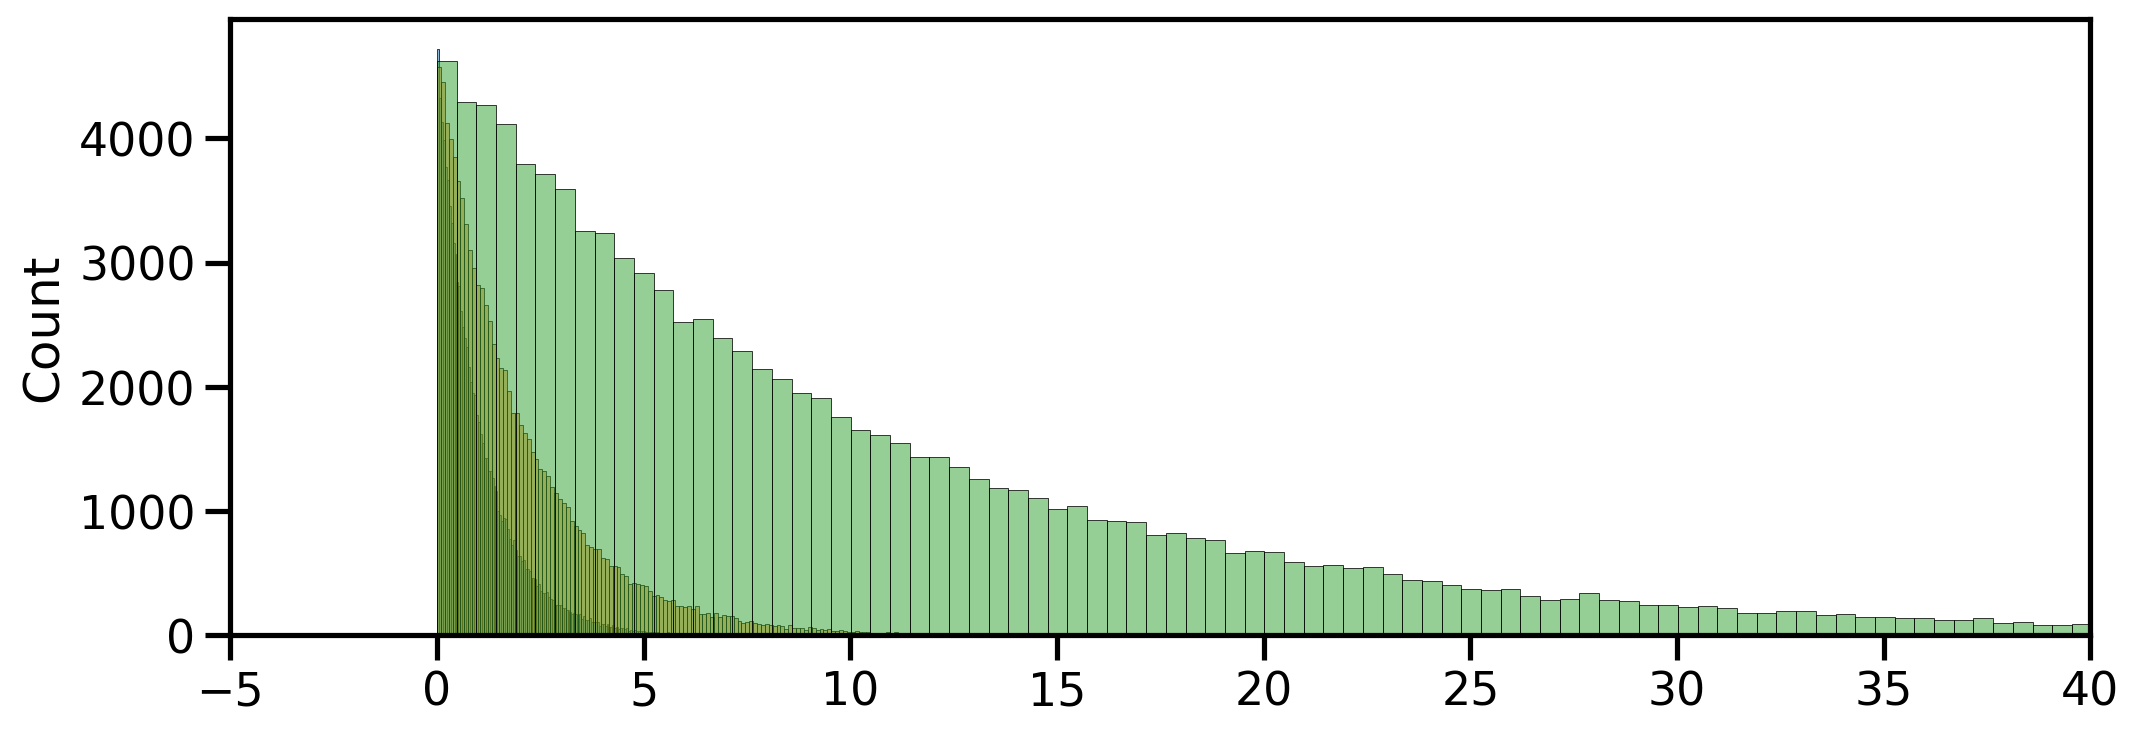

In [72]:
n = 100000
x1 = np.random.exponential(1, size=n)
x2 = np.random.exponential(2, size=n)
x10 = np.random.exponential(10, size=n)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
kwargs = dict(kde=False, alpha=0.5)
sns.histplot(x1, **kwargs, label='Exp(1)', ax=ax)
sns.histplot(x2, **kwargs, label='Exp(2)', ax=ax)
sns.histplot(x10, **kwargs, label='Exp(10)', ax=ax)
ax.set_xlim(-5, 40)

print(x1.mean(), 1)
print(x2.mean(), 2)
print(x10.mean(), 10)

Recall from probability theory that the minimum of $n$ exponentially distributed waiting times is exponentioally distributed; the rate of the minimum is the sum of the rates. 
So, if the waiting times for the different reactions are exponentially distributed with rates $a_i$, then the waiting time for the next reaction (whatever it is) is also exponentially distributed with rate $\sum_i{a_i}$. 

0.6252856415253872 0.625


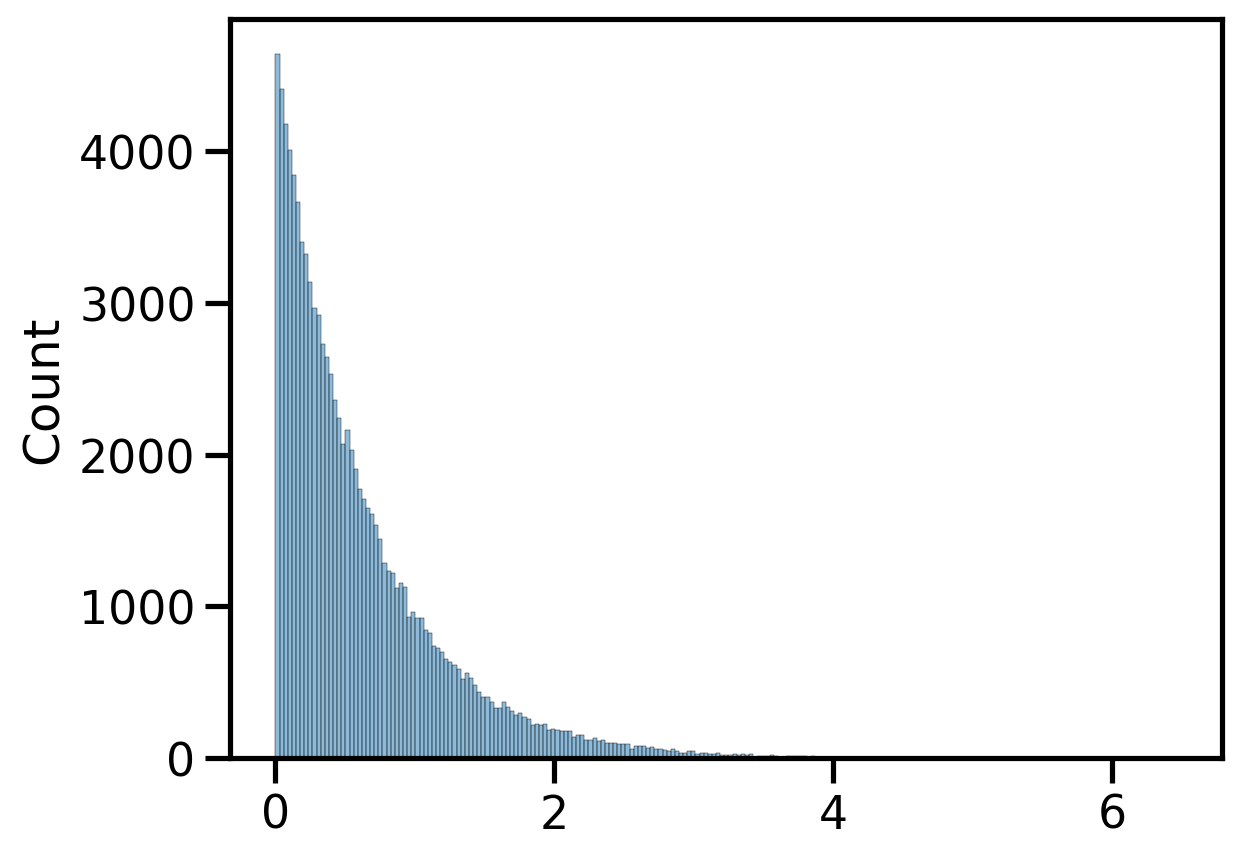

In [74]:
x_min = np.minimum(x1, x2)
x_min = np.minimum(x_min, x10)

sns.histplot(x_min, **kwargs)
ax.set_xlim(-5, 40)

print(x_min.mean(), 1/(1+1/2+1/10))

Given that some reaction occured, the probability that it was reaction $r_i$ is $\frac{a_i}{\sum_j{a_j}}$.

So the algorithm works like this, starting with an initial state $x_0 = (S_0, I_0, R_0)$:
1. Set time $t=0$.
1. Calculate the reaction rates $a_i$ using current state $x_t$.
1. Calculate the sum of rates, $\sum_i{a_i}$.
1. Draw the waiting time for the next reaction $\Delta t$ from exponential distribution $\mathit{Exp}(\sum_i{a_i})$.
1. Draw the type of the reaction from multinomial distribution $\mathit{Multinomial}(1, a_i/\sum_j{a_j})$.
1. Find the state change $\Delta x$ due to reaction $r_i$
1. Update the state $x_{t+\Delta t} = x_t + \Delta x$.
1. Update the time $t \to t + \Delta t$.
1. If not finished (e.g. $t<t_{max}$), go to (2).

## Implementation

First, a function that calculates the reaction rates.

[Numba](http://numba.pydata.org) is used here to accelerate the function by passing it through a JIT compiler.

In [30]:
# @numba.jit # 2-fold faster
def get_rates(S, I, R, β, γ):
    N = S + I + R
    return np.array([
        β*S*I/N, # infection
        γ*I, # recovery
    ])

Draw the time for the next reaction:

In [31]:
# @numba.jit # 2-fold faster
def draw_time(rates):
    total_rate = rates.sum()
    return np.random.exponential(1/total_rate)

Draw the reaction type:

In [32]:
# @numba.jit # jit causes errors with multinomial
def draw_reaction(rates):
    assert (rates>0).any(), rates
    rates /= rates.sum()
    return np.random.multinomial(1, rates).argmax()

In [33]:
rates = get_rates(100, 1, 0, β, γ)
rates /= rates.sum()
draw_reaction(rates)

0

Updates matrix, `updates[i,j]` is the change in reactant `j` due to reaction `i`; `j=0` for mRNA and `j=1` for protein.

In [34]:
updates = np.array([
    [-1, 1, 0], # infection
    [0, -1, 1], # recovery
])

One step of the simulation goes through a single update.

In [35]:
def gillespie_step(S, I, R, β, γ):
    rates = get_rates(S, I, R, β, γ)
    Δt = draw_time(rates)
    ri = draw_reaction(rates)
    ΔS, ΔI, ΔR = updates[ri]
    return Δt, ΔS, ΔI, ΔR

Now a full Gillespie stochastic simulation algorithm. We stop when $t \ge t_{max}$.

`output` keeps track of the simulation results.
The first axis is the record type - time, mRNA, and protein.
The second axis is time.

Note that time is not discrete and time steps are not constant, hence we keep for each time step (axis=1) the time (first array in axis=0).

In [41]:
def gillespie_ssa(β, γ, S0, I0, t_steps=1000, t0=0, tmax=250):
    times = np.linspace(t0, tmax, t_steps) # recording times: time points in which to record the state
    states = np.empty((updates.shape[1], t_steps), dtype=int) # recorded states
    N = S0 + I0
    # init
    t = t0
    S, I, R = S0, I0, 0
    ΔS, ΔI, ΔR = 0, 0, 0
    # loop over recording times
    for i, next_t in enumerate(times):
        # simulate until next recording time
        while t < next_t and I > 0:
            Δt, ΔS, ΔI, ΔR = gillespie_step(S, I, R, β, γ)
            t, S, I, R = t+Δt, S+ΔS, I+ΔI, R+ΔR
        # record the previous state for the time point we just passed
        states[:, i] = S - ΔS, I - ΔI, R - ΔR
    # return array equivalent to [[times, S, I, R] for t in times]
    return np.concatenate((times.reshape(1, -1), states), axis=0)

## Simulation

Run a single simulation and plot it.

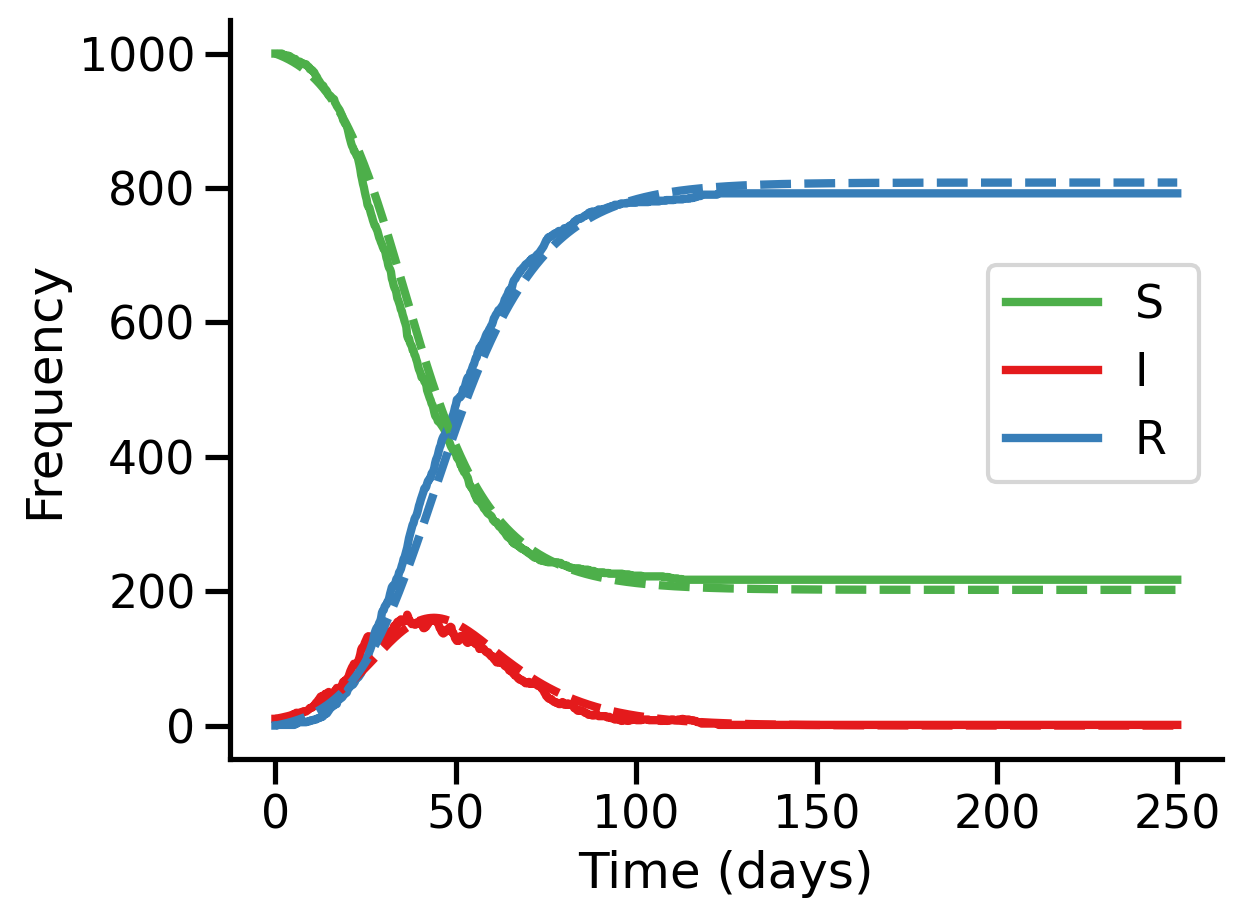

In [42]:
β, γ = 0.2, 0.1
S0, I0 = 1000, 10
N = S0+I0

T, S, I, R = gillespie_ssa(β, γ, S0=S0, I0=I0)
t, s, i, r = numerical_solution(β, γ, I0=I0/(S0+I0))

fig, ax = plt.subplots()
plot_SIR(T, S, I, R, ax=ax)
ax.legend(bbox_to_anchor=(1, 0.7))
plot_SIR(t, s*N, i*N, r*N, ls='--', ax=ax)
sns.despine()

There is quite a lot of noise here!

## Compare stochastic and deterministic
Run the Gillespie algorithm 100 times and compare it to the deterministic dynamics.

In [43]:
%%time
reps = 100
TSIR = np.array([gillespie_ssa(β, γ, S0=S0, I0=I0) for _ in range(reps)]) # accelerate with multiprocessing
t, s, i, r = numerical_solution(β, γ, I0=I0/(S0+I0))

CPU times: user 2.85 s, sys: 24.9 ms, total: 2.87 s
Wall time: 2.87 s


We plot all the simulated trajectories, but with transparency so we can see them all.

We also plot the average trajectory (black solid lines) and the ODE solution (black dashed lines).

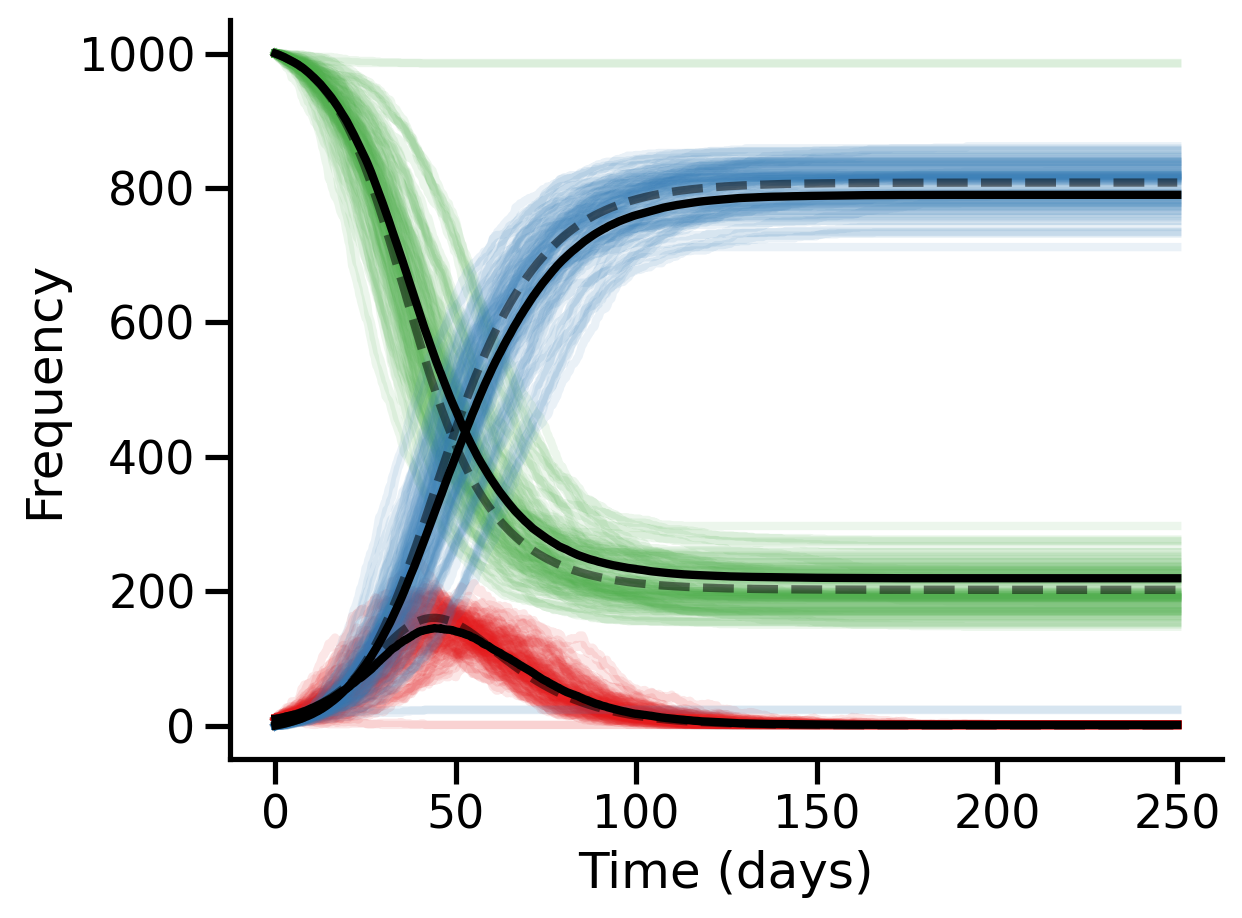

In [67]:
fig, ax = plt.subplots()

# axes of tmp are (replicates, states, times)
T = TSIR[0, 0, :] # time is the same in all replicates, see first line of gillespie_ssa
S = TSIR[:, 1, :]
I = TSIR[:, 2, :]
R = TSIR[:, 3, :]

# plot independent trajectories
plot_SIR(T, S.T, I.T, R.T, ax=ax) 
for line in ax.get_lines(): # transparency
    line.set_alpha(0.1) 

# plot mean of all gillespie trajectories
plot_SIR(T, S.mean(axis=0), I.mean(axis=0), R.mean(axis=0), ax=ax) 
for line in ax.get_lines()[-3:]:
    line.set_color('k')
    
# plot ode solution
plot_SIR(t, s*N, i*N, r*N, ax=ax) 
for line in ax.get_lines()[-3:]:
    line.set_ls('--')
    line.set_color('k')
    line.set_alpha(0.5)
    
ax.legend().set_visible(False)
sns.despine()

We can see that indeed the mean of the stochastic dynamics is very close to the ODE solution, even with just 100 replicates (cells).

Instead of plotting all the trajectories, we can just plot the mean with a 95% confidence interval.

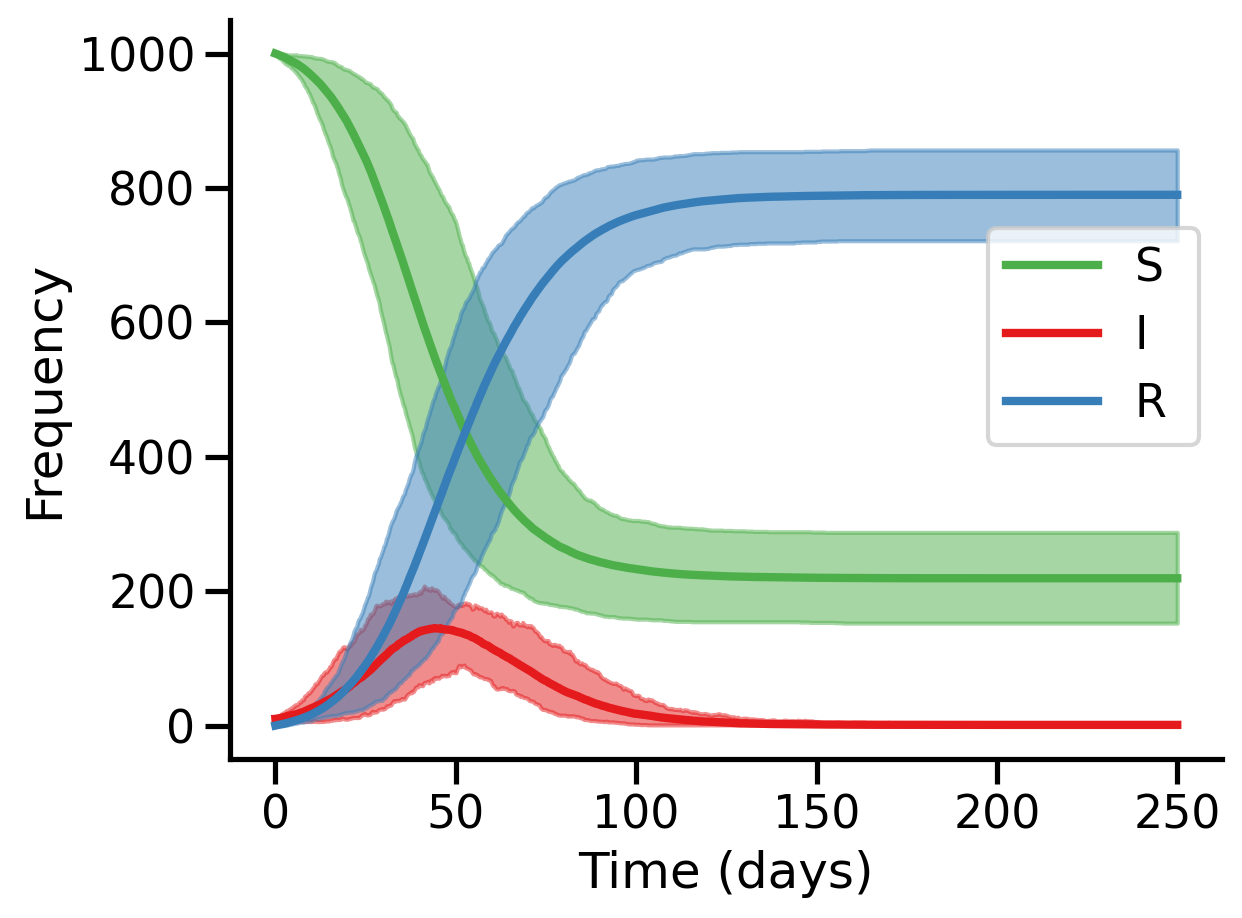

In [70]:
fig, ax = plt.subplots()
plot_SIR(T, S.mean(axis=0), I.mean(axis=0), R.mean(axis=0), ax=ax) # plot mean of all gillespie trajectories
S_low, S_high = np.quantile(S, 0.025, axis=0), np.quantile(S, 0.975, axis=0)
I_low, I_high = np.quantile(I, 0.025, axis=0), np.quantile(I, 0.975, axis=0)
R_low, R_high = np.quantile(R, 0.025, axis=0), np.quantile(R, 0.975, axis=0)
ax.fill_between(t, S_low, S_high, alpha=0.5, color=green)
ax.fill_between(t, I_low, I_high, alpha=0.5, color=red)
ax.fill_between(t, R_low, R_high, alpha=0.5, color=blue)
ax.legend(bbox_to_anchor=(1, 0.75))
sns.despine()

# Parallel simulations with multiprocessing

From the [threading](https://docs.python.org/3/library/threading.html) module:
> CPython implementation detail: In CPython, due to the Global Interpreter Lock, **only one thread can execute Python code at once**... If you want your application to make better use of the **computational resources of multi-core machines**, you are advised to use `multiprocessing` or `concurrent.futures.ProcessPoolExecutor`.

The standard library module, [multiprocessing](https://docs.python.org/3/library/multiprocessing.html), provides low-level interfaces for the use of multiple processes. 

We will use [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html), which provides a high-level API: a process pool.

Tip: If you get a persistent error about broken processes, try to restart the kernel and possibly the notebook server, then debug without the executor (non-parallel) and when it works, re-insert the executor.

In [72]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

In [73]:
f = gillespie_ssa
kwargs = dict(β=β, γ=γ, tmax=250)
cpus = cpu_count()

In [ ]:
# %%time
reps = 1000
print("Running {} simulations on {} CPUs".format(reps, cpus))

with ProcessPoolExecutor(cpus) as executor:
    futures = [executor.submit(f, **kwargs) for _ in range(reps)]

results = []
for fut in as_completed(futures):
    if fut.exception():
        warnings.warn(str(fut.exception()))
    else:
        results.append(fut.result())
results = np.array(results)

# References
- Some of this session follows Justin Bois notes (Caltech BE150 2017), which are not available online anymore.
- Gillespie algorithm on [Wikipedia](https://en.wikipedia.o-rg/wiki/Gillespie_algorithm)
- [StochPy](http://stochpy.sourceforge.net/) - Python package for stochastic simulation
- [SimPy](https://simpy.readthedocs.io/) - Generator based stochastic simulator in Python
- [Jupyter-based Gillespie simualtion tutorial](http://be150.caltech.edu/2017/handouts/gillespie_simulation.html)
- [Python code and original papers](https://github.com/karinsasaki/gillespie-algorithm-python) by Karin Sasaki
- [Mechanisms of noise-resistance in genetic oscillators](http://www.pnas.org/content/99/9/5988.full) - paper by Vilar, Kueh, Barkai, Leibler that uses Gillespie algorithm.
- [Paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0095150) comparing Gillespie simulation with agent-based simulation in cancer modelling.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [Models in Population Biology](http://modelspopbiol.yoavram.com) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.